# Text classification with LLMs

This notebook will go over a basic NLP task, text classification, using the transformer library and pytorch. 

### Description

Twitter has emerged as a vital communication platform during emergencies. With the widespread use of smartphones, individuals can report emergencies they witness in real-time. This capability has sparked growing interest among organizations, such as disaster relief agencies and news outlets, in monitoring Twitter programmatically.

However, distinguishing whether a tweet is genuinely reporting a disaster can be challenging. This competition tasks us with developing a machine learning model to predict which tweets pertain to actual disasters and which do not.

__The workflow is__:
1. Data cleaning preparation
1. Train-Validation-Test split, prepare data loader
1. Download pretrained model
1. Set parameters for fine tuning training
1. Train the model
1. Review results
1. Use the model for prediction

## Imports and data loading 

In [1]:
#  basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import random

# Core packages for text processing.
import string
import re
from nltk.corpus import stopwords, wordnet

# DL packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

import transformers
from transformers import BertForSequenceClassification, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

Set up GPU if available, and seeds for consistent results:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device type is {device}')

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Device type is cuda:0


Some helper functions to calculate our metrics and time spent on the training process:

In [3]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)


def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)


def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Loading the train and test data:

In [4]:
trainv = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testv = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Taking general look at the both datasets.
display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [5]:
# Checking observation and feature numbers for train and test data.

print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


## Data cleaning and tokenization

We need to clean the following from our data:

* html tags
* urls
* symbols
* stopwords
* emojis

In [6]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)


def clean_text(text):
    # make everything lower case
    text = text.lower()
    
    # remove URLs
    text = remove_url(text)
    
    # remove punctuations
    text = remove_punct(text)
    
    # remove emojis
    text = remove_emoji(text)
    
    # remove stopwords
    sw = stopwords.words('english')
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = " ".join(text)
       
    return text

trainv['clean_text'] = trainv['text'].apply(lambda x: clean_text(x))
testv['clean_text']  = testv['text'].apply(lambda x: clean_text(x))

trainv.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In order to feed text to the language model, we need to __tokenize__ the text and __map__ it to an id. A token can be a sub-word: a word can be broken down into more than one sub-word, which helps in dealing with unknown words. 

For best results, it is adviced to tokenize with the same tokenizer the model was trained on. We will use the BERT model first, so we will also use the BERT tokenizer. Using the HuggingFace's transformers library, it comes down to a single line of code. 

The mapping is needed to check whether that token is present in the tokenizer vocabulary. If there’s a token that is not present in the vocabulary, the tokenizer will use the special [UNK] token and use its id.


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

For a single example:

In [8]:
print('Original:     ', trainv['text'].iloc[0])
print('Cleaned text: ', trainv['clean_text'].iloc[0])

# Print the sentence split into tokens.
print('Tokenized:    ', tokenizer.tokenize(trainv['clean_text'].iloc[0]))

# Print the sentence mapped to token ids.
print('Token IDs:    ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(trainv['clean_text'].iloc[0])))

Original:      Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned text:  deeds reason earthquake may allah forgive us
Tokenized:     ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']
Token IDs:     [15616, 3114, 8372, 2089, 16455, 9641, 2149]


Now we need to tokenize an entire dataset.

``` python
tokenizer = AutoTokenizer.from_pretrained(model_id)
inputs = tokenizer(example)
```

Calling `tokenizer(example)` triggers the `tokenizer.__call__` function, which may vary according to implementation.

We will use the `tokenizer.encode_plus` function to tokenize the data.

* It splits the sentences into tokens, then adds special tokens for classificication [CLS]: 
> The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks. (from the BERT paper)
* Adds [SEP] tokens for making BERT decide if sentences are related.
* Maps tokens to IDs.
* Pads or truncates all sentences to same length. For this purpose, we will have to set a `max_length` argument. If a sentence is longer than `max_length` it gets truncated, if it's shorter than `max_length` then it adds [PAD] tokens to get it to the same length.
* Creates attention masks which consist of 1's and 0's for differentiating [PAD] tokens from the actual tokens.

These steps are taken for every entry in the train and test set.

In [9]:
def tokenize_data(data, max_length):
    input_ids = []
    attention_masks = []
    
    for tweet in data['clean_text']:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            tweet,                          # Sentence to encode.
            add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
            truncation='longest_first',     # Activate and control truncation
            max_length = max_length,        # Max length according to our text data.
            padding = 'max_length',         # Pad to max_length
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors = 'pt',          # Return pytorch tensors.
            )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

`encode_plus` requires that we know the maximal sequence length in order to pad/truncate correctly. More advanced applications pick this value per batch. We will pick a global value.

In [10]:
max_length = 0

for tweet in trainv['clean_text']:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tweet, add_special_tokens=True)

    # Update the maximum sentence length.
    max_length = max(max_length, len(input_ids))

print('Max sentence length: ', max_length)

Max sentence length:  53


In [11]:
# Run for the training samples
train_input_ids, train_attention_masks = tokenize_data(trainv, max_length)
labels = torch.tensor(trainv['target'])

# Combine the training inputs into a TensorDataset.
all_train_dataset = TensorDataset(train_input_ids, train_attention_masks, labels)

# Run for test samples
test_input_ids, test_attention_masks= tokenize_data(testv, max_length)

## Prepare data for loading into the model

Create a train-validation split:


In [12]:
percent_train = 0.8

# Calculate the number of samples to include in each set.
train_size = int(percent_train * len(all_train_dataset))
val_size   = len(all_train_dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(all_train_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


The DataLoader needs to know our batch size for training, so we specify it here.

In [13]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(train_dataset,                          # The training samples.
                              sampler = RandomSampler(train_dataset), # Select batches randomly
                              batch_size = batch_size                 # Trains with this batch size.
                             )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(val_dataset,                              # The validation samples.
                                   sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                                   batch_size = batch_size                   # Evaluate with this batch size.
                                  )

# Test dataloader
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_dataloader = DataLoader(prediction_data, 
                                   sampler=SequentialSampler(prediction_data), 
                                   batch_size=batch_size)

## Loading pre-trained BERT model

In [14]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased',                 # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2,                       # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False,            # Whether the model returns attentions weights.
    output_hidden_states = False,         # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

Now define final parameters:

* The hyperparameters (learning_rate, epsilon, epochs etc.) are those recommended.
* Number of epochs: Recommended between 2 and 4.
* AdamW is an optimizer class from the huggingface library, but it produces a deprecation warning. We use pytorch's function instead.
* Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples.)
* Create the learning rate scheduler.

In [15]:
epochs = 4
learning_rate = 8e-6
epsilon = 1e-8

total_steps = len(train_dataloader) * epochs
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate,
                              eps = epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,             # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training and Evaluating

__Training__
* Unpack inputs and labels
* Load data onto the GPU for acceleration
* Clear out the gradients calculated in the previous pass
    * In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
* Forward pass (feed input data through the network)
* Backward pass (backpropagation)
* Update parameters with optimizer.step()
* Track variables for monitoring progress

__Evaluation__
* Unpack inputs and labels
* Load data onto the GPU for acceleration
* Forward pass (feed input data through the network)
* Compute loss on our validation data and track variables for monitoring progress

In [16]:
def training(device, model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs):
    # We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.
    
    training_stats = []
    
    # Measure the total training time for the whole run.
    
    total_t0 = time.time()
    
    # For each epoch...
    
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
    
        print('')
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        # Measure how long the training epoch takes:
        t0 = time.time()
    
        # Reset the total loss for this epoch.
        total_train_loss = 0
    
        # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training vs. test ,
        # source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
        model.train()
    
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every 50 batches.
            if step % 50 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader. 
            # As we unpack the batch, we'll also copy each tensor to the device(gpu in our case) using the `to` method.
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            
            b_input_ids = batch[0].to(device).to(torch.int64)
            b_input_mask = batch[1].to(device).to(torch.int64)
            b_labels = batch[2].to(device).to(torch.int64)
    
            # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because accumulating the gradients is 'convenient while training RNNs'. 
            # Source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
            model.zero_grad()
    
            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is down here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
            # And the 'logits' (the model outputs prior to activation.)
            output = model(b_input_ids,
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels)
            loss = output.loss
            logits = output.logits
    
            # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end, 
            # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
            total_train_loss += loss.item()
    
            # Perform a backward pass to calculate the gradients.
            loss.backward()
    
            # Clip the norm of the gradients to 1.0, This is to help prevent the 'exploding gradients' problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)
            optimizer.step()
    
            # Update the learning rate.
            scheduler.step()
    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
    
        print('')
        print('  Average training loss: {0:.2f}'.format(avg_train_loss))
        print('  Training epcoh took: {:}'.format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on our validation set.
        print('')
        print('Running Validation...')
    
        t0 = time.time()
    
        # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
        model.eval()
    
        # Tracking variables:
        total_eval_accuracy = 0
        total_eval_loss = 0
        total_eval_f1 = 0
        nb_eval_steps = 0
    
        # Evaluate data for one epoch.
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.
                # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.
                output = model(b_input_ids,
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels)
                loss = output.loss
                logits = output.logits
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
    
            # Move logits and labels to CPU:
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
    
            # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            total_eval_f1 += flat_f1(logits, label_ids)
            
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
        
        # Report the final f1 score for this validation run.
        avg_val_f1 = total_eval_f1 / len(validation_dataloader)
        print('  F1: {0:.2f}'.format(avg_val_f1))
    
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took:
        validation_time = format_time(time.time() - t0)
        
        print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
        print('  Validation took: {:}'.format(validation_time))
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Val_F1' : avg_val_f1,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    print('')
    print('Training complete!')
    print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))

    return training_stats, model

In [17]:
training_stats, model = training(device, model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs)


======== Epoch 1 / 4 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:26.
  Batch   100  of    191.    Elapsed: 0:00:53.
  Batch   150  of    191.    Elapsed: 0:01:19.

  Average training loss: 0.47
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:26.
  Batch   100  of    191.    Elapsed: 0:00:52.
  Batch   150  of    191.    Elapsed: 0:01:18.

  Average training loss: 0.36
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.83
  F1: 0.79
  Validation Loss: 0.42
  Validation took: 0:00:08

======== Epoch 3 / 4 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:26.
  Batch   100  of    191.    Elapsed: 0:00:52.
  Batch   150  of    191.    Elapsed: 0:01:19.

  Average training loss: 0.31
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.84
  F1: 0.79
  Valid

## Try a different model

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_id = "bert-base-uncased"

Model:

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                          num_labels=2)

# Tell pytorch to run this model on the device which we set GPU in our case.
model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Tokenization:

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_id, do_lower_case=True)

# some models require that we set what token will be used for padding
# we also need to tell the model to update the token embedding size
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = tokenizer.pad_token

# Run for the training samples
train_input_ids, train_attention_masks = tokenize_data(trainv, max_length)
labels = torch.tensor(trainv['target'])

# Combine the training inputs into a TensorDataset.
all_train_dataset = TensorDataset(train_input_ids, train_attention_masks, labels)

# train-validation split
train_dataset, val_dataset = random_split(all_train_dataset, [train_size, val_size])

# Run for test samples
test_input_ids, test_attention_masks= tokenize_data(testv, max_length)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Data loaders:

In [21]:
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(train_dataset,                          # The training samples.
                              sampler = RandomSampler(train_dataset), # Select batches randomly
                              batch_size = batch_size                 # Trains with this batch size.
                             )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(val_dataset,                              # The validation samples.
                                   sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                                   batch_size = batch_size                   # Evaluate with this batch size.
                                  )

# Test dataloader
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_dataloader = DataLoader(prediction_data, 
                                   sampler=SequentialSampler(prediction_data), 
                                   batch_size=batch_size)

Optimizer and scheduler:

In [22]:
epochs = 5
learning_rate = 2e-5
epsilon = 1e-8

total_steps = len(train_dataloader) * epochs
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = learning_rate,
                              eps = epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,             # Default value in run_glue.py
                                            num_training_steps = total_steps)

Training:

In [23]:
training_stats, model = training(device, model, train_dataloader, validation_dataloader, optimizer, scheduler, epochs)


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:08.
  Batch   100  of    191.    Elapsed: 0:00:16.
  Batch   150  of    191.    Elapsed: 0:00:24.

  Average training loss: 0.47
  Training epcoh took: 0:00:31

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Validation Loss: 0.41
  Validation took: 0:00:02

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:08.
  Batch   100  of    191.    Elapsed: 0:00:16.
  Batch   150  of    191.    Elapsed: 0:00:24.

  Average training loss: 0.34
  Training epcoh took: 0:00:31

Running Validation...
  Accuracy: 0.84
  F1: 0.79
  Validation Loss: 0.42
  Validation took: 0:00:02

======== Epoch 3 / 5 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:08.
  Batch   100  of    191.    Elapsed: 0:00:16.
  Batch   150  of    191.    Elapsed: 0:00:24.

  Average training loss: 0.26
  Training epcoh took: 0:00:31

Running Validation...
  Accuracy: 0.82
  F1: 0.79
  Valid

Statistics summary:

,Training Loss,Valid. Loss,Valid. Accur.,Val_F1,Training Time,Validation Time
epoch,,,,,,
1,0.468631,0.408346,0.828776,0.783194,0:00:31,0:00:02
2,0.342064,0.419230,0.839193,0.790036,0:00:31,0:00:02
3,0.262633,0.502723,0.823568,0.787486,0:00:31,0:00:02
4,0.201672,0.564432,0.824870,0.781954,0:00:31,0:00:02
5,0.156515,0.595595,0.824870,0.787746,0:00:31,0:00:02


([<matplotlib.axis.XTick at 0x7a8491aa5390>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

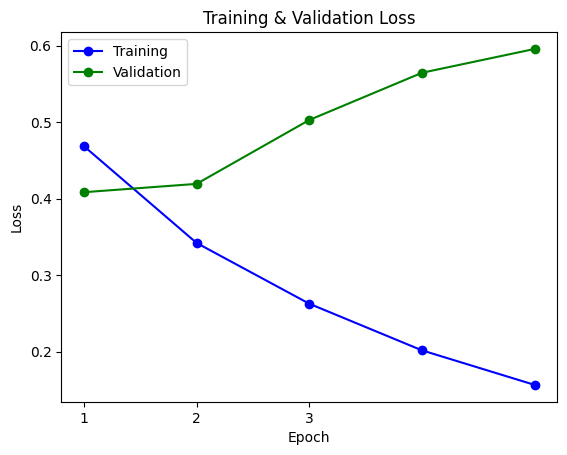

In [24]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
display(df_stats)

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3])

## Preditions and Submission

After training the model, we need to use it to make predictions on the test set, and submit those predictions.

In [25]:
print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:
model.eval()

# Tracking variables :
predictions = []

# Predict:
for batch in prediction_dataloader:
    
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader:
  b_input_ids, b_input_mask, = batch
  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:
  with torch.no_grad():
      # Forward pass, calculate logit predictions:
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU:
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels:
  predictions.append(logits)

print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [26]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Creating submission data.
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = flat_predictions

# Saving submission to '.csv' file:
submission.to_csv('submission.csv', index=False, header=True)

submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


### Conclusion

This project tackled the challenge of accurately distinguishing between real disaster-related tweets and those that are not. Leveraging machine learning techniques, the model's performance highlights the potential of AI in improving disaster response systems by providing real-time, reliable information from social media platforms such as Twitter.

The chosen methodologies, including model selection, feature engineering, and hyperparameter tuning, played crucial roles in optimizing the system's predictive accuracy. These results underscore the value of combining machine learning with social media analytics for rapid and effective disaster management.

Future work could focus on integrating additional data sources, refining natural language processing methods, and ensuring the model's robustness in diverse contexts. Ultimately, this project demonstrates the power of AI to transform emergency response efforts, paving the way for more efficient and informed decision-making in crisis scenarios.